# SETUP

In [1]:
#Load packages
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import *

from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler  


In [2]:
# Functions 
def myCols(string, start, end, npoints):
    Side = np.linspace(start, end, npoints)
    String = string
    Cols = []
    for index,num in enumerate(Side): 
        Col= String + str(int(num)) 
        Cols = [*Cols, Col]
    return Cols

## This function will plot the true vs. predicted with various line fits
def plotSummary(true, predicted, name):
    #from pylab import *
    #import numpy as np
    #import matplotlib.pyplot as plt
    
    figure()
    plt.scatter(true,predicted, alpha = 0.2)
    
    plt.title(name)
    plt.xlabel('True')
    plt.ylabel('Predicted')

    xmin, xmax = plt.xlim()
    plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one

    fit_temp = np.polyfit(true, predicted,1)
    xp = np.linspace(xmin, xmax, 100)
    p = np.poly1d(fit_temp)
    plt.plot(xp, p(xp), '-', color = 'black')
    
    print(' ')
    print('RMSE on test data:', round(np.sqrt(mean_squared_error(true, predicted)),4), 'for ', name)
    print('R^2 Score on test data:', round(r2_score(true, predicted), 4), 'for', name)

    
    return

def myResiduals(testY, predictY):
    ## residuals 1
    i = 0 # resetting i
    iterations = len(testY) # gets number of dots/points
    residual_sum = 0 # initializes sum of residuals
    for i in range (0,iterations): # for every dot/point
       ys = testY # get ys of testing data
       ys = ys.values # take out indexing, data types, names
       y = ys[i]
       predict_ys = predictY.values # get ys of all dots/points
       predict_y = predict_ys[i] # get the y value of the dot/point at specfic x value i
       diff = y - predict_y # find the difference in height
       diff = abs(diff) # take the absolute value
       residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals
    residual_average = residual_sum/iterations # find the average of the residuals
    print('The average residual for predict:', round(residual_average,4)) # display average of residuals

    minY = min(ys) # find the minimum y value for testing data
    maxY = max(ys) # find the max y value for testing data
    minpredict = min(predictY) # find the min y value for the prediction data
    maxpredict = max(predictY) # find the max y value for the prediction data
    #print('minY', minY, 'maxY', maxY)
    #print('minpredict', minpredict, 'maxpredict', maxpredict)
    rangeY = minY + maxY # find the range of the testing data
    rangepredict = minpredict - maxpredict # find the range of the predictions
    #print('rangeY', rangeY)
    #print('rangepredict', rangepredict)
    residual_percent_rangepredict = (residual_average/abs(rangepredict))*100 # calculate what percent the residual is of the range
    print('Residual is this percent of predict range', round(residual_percent_rangepredict,3), '%')
    
    return
    

In [3]:
# Create Column Names
topCol_names = myCols('Top Point ', 0, 450, 451)
bondCol_names = myCols('Bond Point ', 0, 450, 451)
delta_names = ['deltaI', 'deltaR']
col_names = delta_names + topCol_names + bondCol_names

In [147]:
#Load Training Data
data = pd.read_csv('Training_Data/Graphene/ES_AG_Spec_data.csv', header = None, names = col_names) # read the data in 
data.head() # show the data in notebook 

,deltaI,deltaR,Top Point 0,Top Point 1,Top Point 2,Top Point 3,Top Point 4,Top Point 5,Top Point 6,Top Point 7,...,Bond Point 441,Bond Point 442,Bond Point 443,Bond Point 444,Bond Point 445,Bond Point 446,Bond Point 447,Bond Point 448,Bond Point 449,Bond Point 450
0,-0.29103,0.85577,0.52795,0.53265,0.53778,0.54260,0.54788,0.55260,0.55743,0.56266,...,0.92805,0.92393,0.91974,0.91522,0.91128,0.90731,0.90362,0.90001,0.89697,0.89415
1,-0.14798,0.67080,0.58404,0.59002,0.59622,0.60201,0.60811,0.61364,0.61911,0.62482,...,0.93021,0.92652,0.92285,0.91894,0.91560,0.91228,0.90926,0.90635,0.90396,0.90180
2,-1.37130,0.52359,0.32378,0.31895,0.31564,0.31231,0.30992,0.30707,0.30499,0.30387,...,0.93900,0.93652,0.93309,0.92830,0.92359,0.91790,0.91174,0.90474,0.89802,0.89092
3,-0.13607,0.29882,0.73234,0.74244,0.75234,0.76157,0.77068,0.77912,0.78713,0.79506,...,0.95216,0.94967,0.94738,0.94509,0.94330,0.94171,0.94044,0.93937,0.93876,0.93842
4,-0.57749,0.70397,0.45494,0.46095,0.46773,0.47429,0.48146,0.48809,0.49501,0.50251,...,0.93663,0.93119,0.92569,0.91987,0.91473,0.90965,0.90496,0.90044,0.89663,0.89313


In [5]:
# Splitting Data into Training and Testing 
points = data.drop(['deltaI', 'deltaR'], axis = 1) 
deltas = data[['deltaI', 'deltaR']]

testSize = 0.3
randState = 42

points_train, points_test, deltas_train, deltas_test = train_test_split(points, deltas, test_size = testSize, random_state = randState)

# TRAINING MODELS

Decision Tree

In [6]:
#Initialize Model
regr_DT = DecisionTreeRegressor(max_depth=30, min_samples_leaf = 2)

#Fit Model
regr_DT.fit(points_train, deltas_train)

#Use model to predict
deltas_pred_DT = regr_DT.predict(points_test)

 
RMSE on test data: 0.0247 for  deltaI Depth 30
R^2 Score on test data: 0.9969 for deltaI Depth 30
 
RMSE on test data: 0.0227 for  deltaR Depth 30
R^2 Score on test data: 0.9942 for deltaR Depth 30


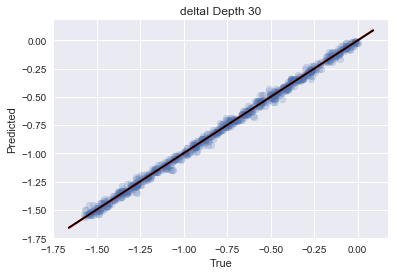

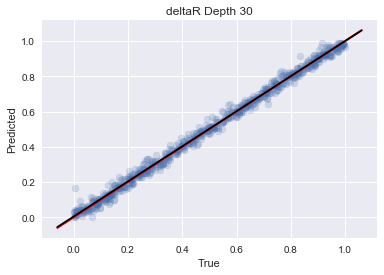

In [7]:
#Plot results
plotSummary(deltas_test['deltaI'], deltas_pred_DT[:,0], 'deltaI Depth 30')
plotSummary(deltas_test['deltaR'], deltas_pred_DT[:,1], 'deltaR Depth 30')

In [8]:
#Print Coefficients/Importances
data = pd.DataFrame(regr_DT.feature_importances_.T, columns = ['Coefficients ']) 
data.index = points_train.columns
print(data[data['Coefficients ']>0.001])

                Coefficients 
Top Point 50         0.038433
Top Point 57         0.006100
Top Point 75         0.009646
Top Point 100        0.009068
Top Point 170        0.002299
Top Point 228        0.003318
Top Point 235        0.102371
Top Point 314        0.005883
Top Point 332        0.001274
Top Point 352        0.033179
Top Point 354        0.001221
Top Point 360        0.002166
Top Point 362        0.002670
Top Point 406        0.002080
Top Point 446        0.532841
Bond Point 0         0.035643
Bond Point 18        0.014046
Bond Point 62        0.001160
Bond Point 68        0.001986
Bond Point 100       0.006254
Bond Point 103       0.001938
Bond Point 162       0.008480
Bond Point 179       0.026942
Bond Point 231       0.110390
Bond Point 262       0.001972
Bond Point 328       0.001756
Bond Point 329       0.002532
Bond Point 359       0.001686
Bond Point 377       0.002671
Bond Point 410       0.002221
Bond Point 449       0.001636


In [9]:
#Trying to understand the scoring
print('Regression - Decision Tree -  Score: ', round(regr_DT.score(points_test,deltas_test), 4),', using max depth of 30')
print(' ')
regressor = DecisionTreeRegressor(random_state=0,max_depth=30, min_samples_leaf=5)
print( 'Cross Validation Scores for regressor with max depth of ', regressor.max_depth, ' : ', cross_val_score(regressor, points, deltas, cv=10))

Regression - Decision Tree -  Score:  0.9961 , using max depth of 30
 
Cross Validation Scores for regressor with max depth of  30  :  [0.9956443  0.99526106 0.99567989 0.99531576 0.99506895 0.99545659
 0.99518424 0.99537331 0.99526284 0.9954314 ]


Random Forest

In [10]:
# Initialize Model 
randState = 42
regr_RF = RandomForestRegressor(max_depth = 15, n_estimators = 15, random_state=randState)

# Fit Model 
model_RF = regr_RF.fit(points_train, deltas_train)

# Use Model to Predict 
predict_RF = model_RF.predict(points_test)

# Find Importances
importance_RF_10 = pd.Series(model_RF.feature_importances_, index = points_train.columns)


 
RMSE on test data: 0.0097 for  deltaI 15x15
R^2 Score on test data: 0.9995 for deltaI 15x15
 
RMSE on test data: 0.0104 for  deltaR 15x15
R^2 Score on test data: 0.9988 for deltaR 15x15

 Score - Random Forest: 0.9993 for delta I/R 15x15


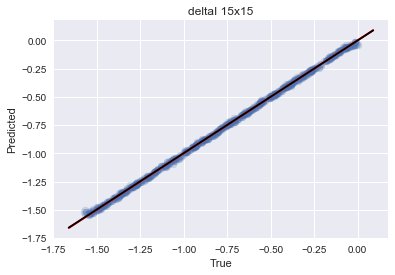

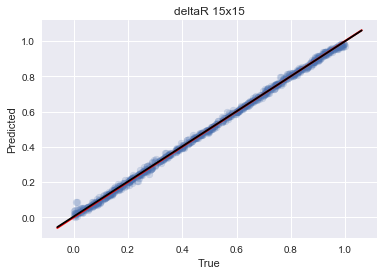

In [11]:
# Plot Results 
plotSummary(deltas_test['deltaI'], predict_RF[:,0], 'deltaI 15x15')
plotSummary(deltas_test['deltaR'], predict_RF[:,1], 'deltaR 15x15')

print('\n Score - Random Forest:' , round(model_RF.score(points_test, deltas_test),4), 'for delta I/R 15x15')

# TESTING WITH EXPERIMENTAL DATA

In [148]:
#Load Experimental Data
data_exp = pd.read_csv('Training_Data/Graphene/ES_AG_Exp_data.csv', header = None, names = col_names) # read the data in 
data_exp.head() # show the data in notebook 

,deltaI,deltaR,Top Point 0,Top Point 1,Top Point 2,Top Point 3,Top Point 4,Top Point 5,Top Point 6,Top Point 7,...,Bond Point 441,Bond Point 442,Bond Point 443,Bond Point 444,Bond Point 445,Bond Point 446,Bond Point 447,Bond Point 448,Bond Point 449,Bond Point 450
0,0.1,0.1,0.74095,1.0937,0.98544,1.0485,1.0155,1.0431,1.0318,1.0431,...,1.0368,1.0407,1.0411,1.0484,1.0385,1.0555,1.0324,1.072,1.0134,1.128


In [13]:
# Splitting Data into points and deltas
points_exp = data_exp.drop(['deltaI', 'deltaR'], axis = 1) 
deltas_exp = data_exp[['deltaI', 'deltaR']]


In [14]:
#Use Decision Tree model to predict
deltas_pred_DT_exp = regr_DT.predict(points_exp)

In [15]:
# Print Deltas 
print(deltas_pred_DT_exp)

[[-0.156145  0.31706 ]]


In [16]:
# Use Random Forest model to predict
predict_RF_exp = model_RF.predict(points_exp)

In [17]:
# Print Deltas 
print(predict_RF_exp)

[[-0.11630681  0.20520943]]
